# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pandas.plotting import table
import datetime
from time import time
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score, confusion_matrix

plt.style.use('ggplot')

## 2. Exploratory Data Analysis

### 2.1 Load Data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 2.2 Describe/Explore Data

#### 2.2.a Portfolio data

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [6]:
# Check for NaN's

portfolio.isnull().values.any()

False

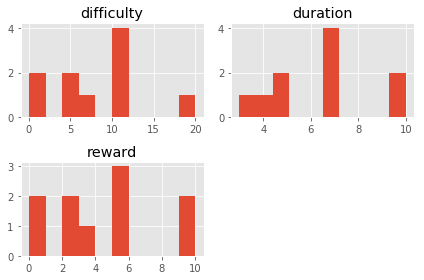

In [7]:
portfolio.hist()
plt.tight_layout();

plt.savefig('portfolio_hist.png')

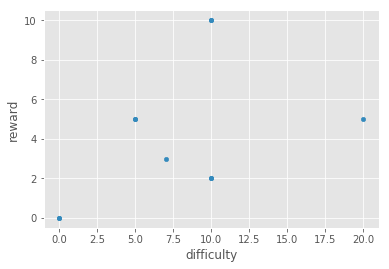

In [8]:
portfolio.plot.scatter('difficulty', 'reward');

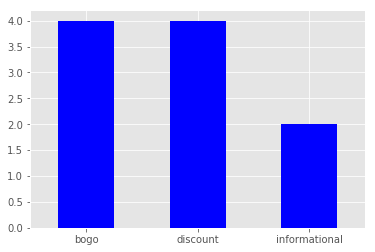

In [9]:
# Distribution of 'offer_type'
portfolio['offer_type'].value_counts().plot(kind='bar', color='b', rot=0);

plt.savefig('portfolio_offer_type.png')

#### 2.2.b Profile data

In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [12]:
profile[['age', 'income']].describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


In [13]:
def table_to_img(df, filename):
    '''
    Saves Pandas dataframe to a .png file
    
    input: df - dataframe
    output: png file
    '''
    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111, frame_on=False)
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis

    the_table = table(ax, df, 
                      loc='center',
                      colWidths = [0.15, 0.15])
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(1.5, 1.5)
    
    fig.tight_layout()

    plt.savefig(filename + '.png')

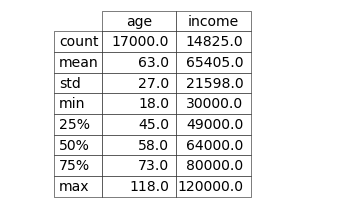

In [14]:
table_to_img(profile[['age', 'income']].describe().round(), 'profile_desc')

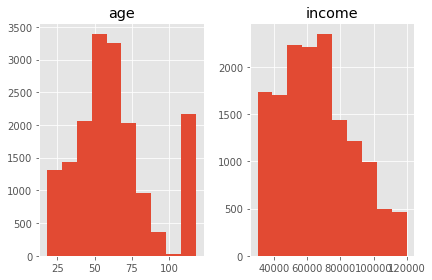

In [15]:
profile[['age', 'income']].hist()
plt.tight_layout();

plt.savefig('profile_hist.png')

In [16]:
# Check for Nulls's
profile.isnull().values.any()

True

In [17]:
# Review rows that contain Null value
profile_nans = profile[profile['income'].isnull().values == True]
profile_nans.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [18]:
profile_nans[['age', 'income']].describe()

,age,income
count,2175.0,0.0
mean,118.0,NaN
std,0.0,NaN
min,118.0,NaN
25%,118.0,NaN
50%,118.0,NaN
75%,118.0,NaN
max,118.0,NaN


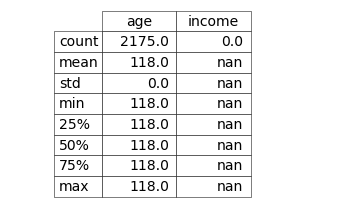

In [19]:
table_to_img(profile_nans[['age', 'income']].describe(), 'profile_nans')

All rows that contain NaN values are missing data for 'age' (all ages are listed as 118, which is highly improbable), 'gender', and 'income'. These rows will not provide us with relevent data for analysis, so these rows should be removed.

In [20]:
profile[~profile['income'].isnull().values == True].describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


#### 2.2.c Transcript data

In [21]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [22]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [23]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


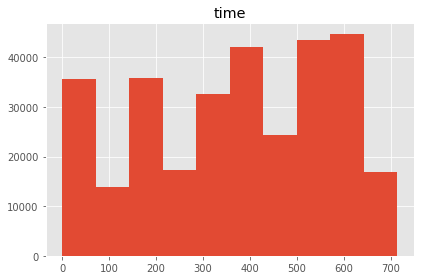

In [24]:
transcript.hist()
plt.tight_layout();

plt.savefig('transcript_hist.png')

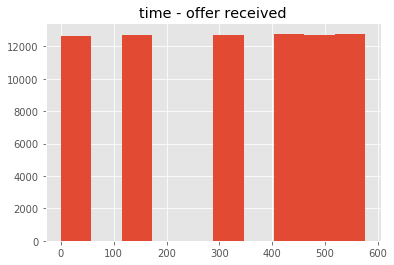

In [25]:
transcript[transcript['event'] == 'offer received'].hist()
plt.title('time - offer received');

plt.savefig('transcript_hist2.png')

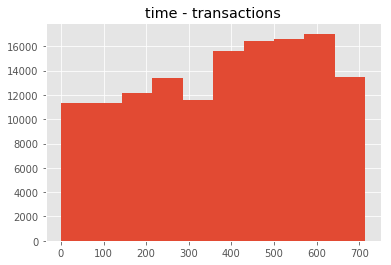

In [26]:
transcript[transcript['event'] == 'transaction'].hist()
plt.title('time - transactions');

plt.savefig('transcript_hist3.png')

## 3. Data Preprocessing

### 3.1 Clean Data

#### 3.1.a Cleaning Portfolio data

- **channel** 
    - create individual columns for variables
- **duration**
    - convert days to hours

In [27]:
# Create copies of loaded data sets
portfolio_new = portfolio.copy()
profile_new = profile.copy()
transcript_new = transcript.copy()

In [28]:
# Create dummies for each channel in lists within the 'channels' column
# then remove 'channels' column.
mlb = MultiLabelBinarizer()

portfolio_new = pd.concat([portfolio_new, 
                          pd.DataFrame(mlb.fit_transform(portfolio_new['channels']),columns=mlb.classes_, index=portfolio_new.index)],
                          axis=1, sort=False
                         )

portfolio_new = portfolio_new.drop('channels', axis=1)

portfolio_new.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [29]:
# Create a field for 'duration'. This will measure the length of each offer
portfolio_new['duration'] = portfolio_new['duration'] * 24

In [30]:
# One-hot encode categorical features
portfolio_new = pd.get_dummies(portfolio_new, columns = ['difficulty', 'reward', 'offer_type'])
portfolio_new.head()

,duration,id,email,mobile,social,web,difficulty_0,difficulty_5,difficulty_7,difficulty_10,difficulty_20,reward_0,reward_2,reward_3,reward_5,reward_10,offer_type_bogo,offer_type_discount,offer_type_informational
0,168,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0
1,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0
2,96,3f207df678b143eea3cee63160fa8bed,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1
3,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
4,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0


In [31]:
# Rename 'id' field to 'offer id' for consistency
portfolio_new.rename(columns={'id': 'offer id'}, inplace=True)

In [32]:
portfolio_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 19 columns):
duration                    10 non-null int64
offer id                    10 non-null object
email                       10 non-null int64
mobile                      10 non-null int64
social                      10 non-null int64
web                         10 non-null int64
difficulty_0                10 non-null uint8
difficulty_5                10 non-null uint8
difficulty_7                10 non-null uint8
difficulty_10               10 non-null uint8
difficulty_20               10 non-null uint8
reward_0                    10 non-null uint8
reward_2                    10 non-null uint8
reward_3                    10 non-null uint8
reward_5                    10 non-null uint8
reward_10                   10 non-null uint8
offer_type_bogo             10 non-null uint8
offer_type_discount         10 non-null uint8
offer_type_informational    10 non-null uint8
dtypes: int64(5), objec

#### 3.1.b Cleaning Profile data

- **became_member_on** 
    - change to datetime type
- **id**
    - change title to "customer_id"
- remove rows that contain NaN values

In [33]:
# Change 'became_member_on' field to datetime data type
profile_new['became_member_on'] = profile_new['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [34]:
profile_new['became_member_on_year'] = pd.DatetimeIndex(profile_new['became_member_on']).year
profile_new['became_member_on_month'] = pd.DatetimeIndex(profile_new['became_member_on']).month

In [35]:
# Change 'id' field name to 'customer_id' for consistency
profile_new.rename(columns={'id': 'customer_id'}, inplace=True)

In [36]:
# Remove rows with NaN values
profile_new = profile_new.dropna()

In [37]:
# Create 'age_group' and 'income_group' fields to categorize age and income
bins = pd.IntervalIndex.from_tuples([(17, 24), (24, 35), (35, 50), (50, 75), (75, 110)])
profile_new['age_group'] = pd.cut(profile_new['age'], bins=bins)
profile_new = profile_new.drop('age', axis=1)

In [38]:
profile_new['income_group'] = pd.cut(profile_new['income'], bins=5)
profile_new = profile_new.drop('income', axis=1)

In [39]:
# One-hot encode 'gender', 'age_group', and 'income_group' fields
profile_new = pd.get_dummies(profile_new, columns = ['gender', 'age_group', 'income_group','became_member_on_year', 'became_member_on_month'])

In [40]:
profile_new.head()

,became_member_on,customer_id,gender_F,gender_M,gender_O,"age_group_(17, 24]","age_group_(24, 35]","age_group_(35, 50]","age_group_(50, 75]","age_group_(75, 110]",...,became_member_on_month_3,became_member_on_month_4,became_member_on_month_5,became_member_on_month_6,became_member_on_month_7,became_member_on_month_8,became_member_on_month_9,became_member_on_month_10,became_member_on_month_11,became_member_on_month_12
1,2017-07-15,0610b486422d4921ae7d2bf64640c50b,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
5,2018-04-26,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
8,2018-02-09,389bc3fa690240e798340f5a15918d5c,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [41]:
profile_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 33 columns):
became_member_on                     14825 non-null datetime64[ns]
customer_id                          14825 non-null object
gender_F                             14825 non-null uint8
gender_M                             14825 non-null uint8
gender_O                             14825 non-null uint8
age_group_(17, 24]                   14825 non-null uint8
age_group_(24, 35]                   14825 non-null uint8
age_group_(35, 50]                   14825 non-null uint8
age_group_(50, 75]                   14825 non-null uint8
age_group_(75, 110]                  14825 non-null uint8
income_group_(29910.0, 48000.0]      14825 non-null uint8
income_group_(48000.0, 66000.0]      14825 non-null uint8
income_group_(66000.0, 84000.0]      14825 non-null uint8
income_group_(84000.0, 102000.0]     14825 non-null uint8
income_group_(102000.0, 120000.0]    14825 non-null uint8
became_memb

#### 3.1.c Cleaning Transcript data

- **person**
    - change title to "customer_id"

In [42]:
transcript_new.rename(columns={'person':'customer_id'}, inplace=True)

In [43]:
# Sort transcript_new by 'person' and 'time'
transcript_new = transcript_new.set_index(['customer_id', 'time']).sort_values(by=['customer_id', 'time']).reset_index()
transcript_new.head()

,customer_id,time,event,value
0,0009655768c64bdeb2e877511632db8f,168,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
2,0009655768c64bdeb2e877511632db8f,228,transaction,{'amount': 22.16}
3,0009655768c64bdeb2e877511632db8f,336,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'}


In [44]:
# Break out the various dictionary keys within 'value' field as their own columns
# then return the respective values for each 'time' value
transcript_new = pd.concat([transcript_new.drop(['value'], axis=1), transcript_new['value'].apply(pd.Series)], axis=1)
transcript_new.head(10)

,customer_id,time,event,offer id,amount,offer_id,reward
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
5,0009655768c64bdeb2e877511632db8f,408,offer received,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
6,0009655768c64bdeb2e877511632db8f,414,transaction,NaN,8.57,NaN,NaN
7,0009655768c64bdeb2e877511632db8f,414,offer completed,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0
8,0009655768c64bdeb2e877511632db8f,456,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
9,0009655768c64bdeb2e877511632db8f,504,offer received,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN


In [45]:
transcript_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
customer_id    306534 non-null object
time           306534 non-null int64
event          306534 non-null object
offer id       134002 non-null object
amount         138953 non-null float64
offer_id       33579 non-null object
reward         33579 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 16.4+ MB


In [46]:
# Fill Null values with 0 for 'amount' and 'reward' fields
transcript_new['amount'] = transcript_new['amount'].fillna(0)
transcript_new['reward'] = transcript_new['reward'].fillna(0)

In [47]:
# Move the non Null values in 'offer_id' to 'offer id'
# then remove 'offer_id' column
transcript_new['offer id'] = transcript_new['offer id'].fillna(transcript_new['offer_id'])
transcript_new = transcript_new.drop(columns='offer_id', axis=1)
transcript_new.head(10)

,customer_id,time,event,offer id,amount,reward
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,0.0
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,0.00,0.0
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,0.00,0.0
5,0009655768c64bdeb2e877511632db8f,408,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
6,0009655768c64bdeb2e877511632db8f,414,transaction,NaN,8.57,0.0
7,0009655768c64bdeb2e877511632db8f,414,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0
8,0009655768c64bdeb2e877511632db8f,456,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0
9,0009655768c64bdeb2e877511632db8f,504,offer received,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0


In [48]:
transcript_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
customer_id    306534 non-null object
time           306534 non-null int64
event          306534 non-null object
offer id       167581 non-null object
amount         306534 non-null float64
reward         306534 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


In [49]:
print(transcript.shape)
print(transcript_new.shape)

(306534, 4)
(306534, 6)


In [50]:
transcript_new[transcript_new['offer id'].isnull()].head()

,customer_id,time,event,offer id,amount,reward
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,0.0
6,0009655768c64bdeb2e877511632db8f,414,transaction,NaN,8.57,0.0
10,0009655768c64bdeb2e877511632db8f,528,transaction,NaN,14.11,0.0
13,0009655768c64bdeb2e877511632db8f,552,transaction,NaN,13.56,0.0
15,0009655768c64bdeb2e877511632db8f,576,transaction,NaN,10.27,0.0


In [51]:
transcript_new[transcript_new['offer id'].isnull()]['event'].value_counts()

transaction    138953
Name: event, dtype: int64

### 3.2 Creating master Data

In [52]:
# Merge 'portfolio_new' fields into 'transcript_new' table
transcript_new = transcript_new.merge(portfolio_new, on='offer id', how='left')
transcript_new.head()

,customer_id,time,event,offer id,amount,reward,duration,email,mobile,social,...,difficulty_10,difficulty_20,reward_0,reward_2,reward_3,reward_5,reward_10,offer_type_bogo,offer_type_discount,offer_type_informational
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,72.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,72.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,0.00,0.0,96.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,0.00,0.0,96.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [53]:
# Rename columns
transcript_new.rename(columns={'email': 'offer_email',
                               'mobile': 'offer_mobile',
                               'social': 'offer_social',
                               'web': 'offer_web'}, inplace=True)

In [54]:
# Merge 'profile_new' fields into 'transcript_new' table
transcript_new = transcript_new.merge(profile_new, on='customer_id', how='left')

In [55]:
transcript_new.head()

,customer_id,time,event,offer id,amount,reward,duration,offer_email,offer_mobile,offer_social,...,became_member_on_month_3,became_member_on_month_4,became_member_on_month_5,became_member_on_month_6,became_member_on_month_7,became_member_on_month_8,became_member_on_month_9,became_member_on_month_10,became_member_on_month_11,became_member_on_month_12
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,72.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,72.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,0.0,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,0.00,0.0,96.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,0.00,0.0,96.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
transcript_new.shape

(306534, 56)

In [57]:
transcript_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 56 columns):
customer_id                          306534 non-null object
time                                 306534 non-null int64
event                                306534 non-null object
offer id                             167581 non-null object
amount                               306534 non-null float64
reward                               306534 non-null float64
duration                             167581 non-null float64
offer_email                          167581 non-null float64
offer_mobile                         167581 non-null float64
offer_social                         167581 non-null float64
offer_web                            167581 non-null float64
difficulty_0                         167581 non-null float64
difficulty_5                         167581 non-null float64
difficulty_7                         167581 non-null float64
difficulty_10                        167

In [58]:
# Calculate number of Null values
transcript_new[transcript_new['offer id'].isnull()]['event'].value_counts(dropna=False)

transaction    138953
Name: event, dtype: int64

In [59]:
# Create list of customers with no profile
# then remove these customers from the analysis
missing_customers = []
for cust in list(set(transcript_new['customer_id'])):
    if cust not in list(set(profile_new['customer_id'])):
        missing_customers.append(cust)
            
len(missing_customers)

2175

In [60]:
# Keep only 'customer_id' items that have a profile
transcript_new = transcript_new[~transcript_new['customer_id'].isin(missing_customers)]
transcript_new.head(10)

,customer_id,time,event,offer id,amount,reward,duration,offer_email,offer_mobile,offer_social,...,became_member_on_month_3,became_member_on_month_4,became_member_on_month_5,became_member_on_month_6,became_member_on_month_7,became_member_on_month_8,became_member_on_month_9,became_member_on_month_10,became_member_on_month_11,became_member_on_month_12
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,72.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,72.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,228,transaction,NaN,22.16,0.0,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,0.00,0.0,96.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,0.00,0.0,96.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0009655768c64bdeb2e877511632db8f,408,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0,120.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0009655768c64bdeb2e877511632db8f,414,transaction,NaN,8.57,0.0,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0009655768c64bdeb2e877511632db8f,414,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0,120.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0009655768c64bdeb2e877511632db8f,456,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0,120.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0009655768c64bdeb2e877511632db8f,504,offer received,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0,240.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
transcript_new.shape

(272762, 56)

In [62]:
transcript_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306533
Data columns (total 56 columns):
customer_id                          272762 non-null object
time                                 272762 non-null int64
event                                272762 non-null object
offer id                             148805 non-null object
amount                               272762 non-null float64
reward                               272762 non-null float64
duration                             148805 non-null float64
offer_email                          148805 non-null float64
offer_mobile                         148805 non-null float64
offer_social                         148805 non-null float64
offer_web                            148805 non-null float64
difficulty_0                         148805 non-null float64
difficulty_5                         148805 non-null float64
difficulty_7                         148805 non-null float64
difficulty_10                        148

In [63]:
# Fill Null's with 0 (for int values) or X (for str values)

def fill_nan(df):

    fill_0 = ['float64', 'int64']

    for col in df:
        if df[col].dtype in fill_0:
            df[col].fillna(0, inplace=True)
        else:
            df[col].fillna('X', inplace=True)
            
    return df

In [64]:
fill_nan(transcript_new)

,customer_id,time,event,offer id,amount,reward,duration,offer_email,offer_mobile,offer_social,...,became_member_on_month_3,became_member_on_month_4,became_member_on_month_5,became_member_on_month_6,became_member_on_month_7,became_member_on_month_8,became_member_on_month_9,became_member_on_month_10,became_member_on_month_11,became_member_on_month_12
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,72.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0.00,0.0,72.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,228,transaction,X,22.16,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed,0.00,0.0,96.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed,0.00,0.0,96.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0009655768c64bdeb2e877511632db8f,408,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0,120.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0009655768c64bdeb2e877511632db8f,414,transaction,X,8.57,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0009655768c64bdeb2e877511632db8f,414,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.0,120.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0009655768c64bdeb2e877511632db8f,456,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,0.00,0.0,120.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0009655768c64bdeb2e877511632db8f,504,offer received,fafdcd668e3743c1bb461111dcafc2a4,0.00,0.0,240.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# Split 'transcript_new' into two different datasets
# One dataset for only transaction events
# One dataset for all other events
customer_offer_summary = transcript_new[transcript_new['event'] != 'transaction']
customer_transactions = transcript_new[transcript_new['event'] == 'transaction'][['customer_id', 'time', 'amount']]

In [66]:
customer_offer_summary.shape

(148805, 56)

In [67]:
customer_transactions.shape

(123957, 3)

In [68]:
def df_formatter(df):
    #separate each 'event' type into its own column with the value being equal to the 'time' value.
    col_group = list(df.drop(['event', 'time', 'reward'], axis=1).columns)
    col_group.append('event')
    
    df = df.groupby(col_group)['time'].agg('first').unstack().reset_index()
    
    # Fill NaN values with 0
    df.fillna(pd.Series(0, index=df.select_dtypes(exclude='category').columns), inplace=True)
    
    return df

In [69]:
customer_offer_summary_flat = df_formatter(customer_offer_summary)
customer_offer_summary_flat.head()

event,customer_id,offer id,amount,duration,offer_email,offer_mobile,offer_social,offer_web,difficulty_0,difficulty_5,...,became_member_on_month_6,became_member_on_month_7,became_member_on_month_8,became_member_on_month_9,became_member_on_month_10,became_member_on_month_11,became_member_on_month_12,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,168.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,576.0,576.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,96.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,336.0,372.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,72.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,168.0,192.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0.0,120.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,414.0,408.0,456.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0.0,240.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,528.0,504.0,540.0


In [70]:
# Create an 'offer expiration' field
customer_offer_summary_flat['offer expiration'] = customer_offer_summary_flat['offer received'] + customer_offer_summary_flat['duration']
customer_offer_summary_flat.head(10)

event,customer_id,offer id,amount,duration,offer_email,offer_mobile,offer_social,offer_web,difficulty_0,difficulty_5,...,became_member_on_month_7,became_member_on_month_8,became_member_on_month_9,became_member_on_month_10,became_member_on_month_11,became_member_on_month_12,offer completed,offer received,offer viewed,offer expiration
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,168.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,576.0,576.0,0.0,744.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,96.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,336.0,372.0,432.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,72.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,168.0,192.0,240.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0.0,120.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,414.0,408.0,456.0,528.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0.0,240.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,528.0,504.0,540.0,744.0
5,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,240.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,576.0,408.0,432.0,648.0
6,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,168.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,252.0,168.0,186.0,336.0
7,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,96.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,96.0
8,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.0,72.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,336.0,354.0,408.0
9,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,168.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,576.0,504.0,516.0,672.0


In [71]:
customer_offer_summary_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55222 entries, 0 to 55221
Data columns (total 57 columns):
customer_id                          55222 non-null object
offer id                             55222 non-null object
amount                               55222 non-null float64
duration                             55222 non-null float64
offer_email                          55222 non-null float64
offer_mobile                         55222 non-null float64
offer_social                         55222 non-null float64
offer_web                            55222 non-null float64
difficulty_0                         55222 non-null float64
difficulty_5                         55222 non-null float64
difficulty_7                         55222 non-null float64
difficulty_10                        55222 non-null float64
difficulty_20                        55222 non-null float64
reward_0                             55222 non-null float64
reward_2                             55222 non-null f

In [72]:
customer_transactions.head()

,customer_id,time,amount
2,0009655768c64bdeb2e877511632db8f,228,22.16
6,0009655768c64bdeb2e877511632db8f,414,8.57
10,0009655768c64bdeb2e877511632db8f,528,14.11
13,0009655768c64bdeb2e877511632db8f,552,13.56
15,0009655768c64bdeb2e877511632db8f,576,10.27


In [73]:
# trans_amounts = []

# for idx, row in enumerate(customer_offer_summary_flat.iterrows()):
#     trans_amount_list = []
#     cust_id = customer_offer_summary_flat.iloc[idx]['customer_id']
#     cust_trans = customer_transactions[customer_transactions['customer_id'] == cust_id]
    
#     for i, j in enumerate(cust_trans.iterrows()):
#         trans_time = cust_trans.iloc[i]['time']
#         trans_amount = cust_trans.iloc[i]['amount']
#         if ((trans_time >= customer_offer_summary_flat.iloc[idx]['offer received']) & \
#            (trans_time <= customer_offer_summary_flat.iloc[idx]['offer completed'])) | \
#             ((customer_offer_summary_flat.iloc[idx]['offer_type_informational'] == 1) & \
#             (customer_offer_summary_flat.iloc[idx]['offer viewed'] > 0) & \
#             (trans_time >= customer_offer_summary_flat.iloc[idx]['offer viewed']) & \
#             (trans_time <= customer_offer_summary_flat.iloc[idx]['offer expiration'])):
#             trans_amount_list.append(trans_amount)
#     trans_amounts.append(trans_amount_list)

# with open('trans_amounts.pkl', 'wb') as f:
#     pickle.dump(trans_amounts, f)

In [74]:
with open('trans_amounts.pkl', 'rb') as f:
    trans_amounts = pickle.load(f)

In [75]:
len(trans_amounts)

55222

In [76]:
customer_offer_summary_flat['trans amounts'] = trans_amounts

In [77]:
customer_offer_summary_flat.head()

event,customer_id,offer id,amount,duration,offer_email,offer_mobile,offer_social,offer_web,difficulty_0,difficulty_5,...,became_member_on_month_8,became_member_on_month_9,became_member_on_month_10,became_member_on_month_11,became_member_on_month_12,offer completed,offer received,offer viewed,offer expiration,trans amounts
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,168.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,576.0,576.0,0.0,744.0,[10.27]
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,96.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,336.0,372.0,432.0,[8.57]
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,72.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,168.0,192.0,240.0,[22.16]
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0.0,120.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,414.0,408.0,456.0,528.0,[8.57]
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0.0,240.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,528.0,504.0,540.0,744.0,[14.11]


In [78]:
# Create a column that sums all the 'trans amounts' for each row
customer_offer_summary_flat['trans_total'] = customer_offer_summary_flat['trans amounts'].apply(lambda x: sum(x))

customer_offer_summary_flat = customer_offer_summary_flat.drop('trans amounts', axis=1)

customer_offer_summary_flat.head()

event,customer_id,offer id,amount,duration,offer_email,offer_mobile,offer_social,offer_web,difficulty_0,difficulty_5,...,became_member_on_month_8,became_member_on_month_9,became_member_on_month_10,became_member_on_month_11,became_member_on_month_12,offer completed,offer received,offer viewed,offer expiration,trans_total
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,168.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,576.0,576.0,0.0,744.0,10.27
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,96.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,336.0,372.0,432.0,8.57
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,72.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,168.0,192.0,240.0,22.16
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0.0,120.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,414.0,408.0,456.0,528.0,8.57
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0.0,240.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,528.0,504.0,540.0,744.0,14.11


In [79]:
# Identify the instences in which a customer received an offer, then viewed it, then completed it
# These are the customers who you would want to focus on sending offers to
customer_offer_summary_flat['offer received_viewed_completed'] = np.where((customer_offer_summary_flat['offer viewed'] > 0) & \
                                                                     (customer_offer_summary_flat['offer completed'] > 0), 1, 0).astype(float)

# Identify the instences in which a customer received an offer, completed completed the offer, but did not viewed it
# These are the customers who make purchases regardless if an offer is given or not. Time and money does not need to be spent
# on sending these customers offers.
customer_offer_summary_flat['offer completed_wo_view'] = np.where((customer_offer_summary_flat['offer viewed'] == 0) & \
                                                             (customer_offer_summary_flat['offer completed'] > 0), 1, 0).astype(float)

customer_offer_summary_flat['informational offer completed'] = np.where((customer_offer_summary_flat['offer_type_informational'] == 1) & \
                                                             (customer_offer_summary_flat['offer viewed'] > 0) & \
                                                             (customer_offer_summary_flat['trans_total'] > 0), 1, 0).astype(float)


customer_offer_summary_flat.head()

event,customer_id,offer id,amount,duration,offer_email,offer_mobile,offer_social,offer_web,difficulty_0,difficulty_5,...,became_member_on_month_11,became_member_on_month_12,offer completed,offer received,offer viewed,offer expiration,trans_total,offer received_viewed_completed,offer completed_wo_view,informational offer completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,168.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,576.0,576.0,0.0,744.0,10.27,0.0,1.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,96.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,336.0,372.0,432.0,8.57,0.0,0.0,1.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,72.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,168.0,192.0,240.0,22.16,0.0,0.0,1.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0.0,120.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,414.0,408.0,456.0,528.0,8.57,1.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0.0,240.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,528.0,504.0,540.0,744.0,14.11,1.0,0.0,0.0


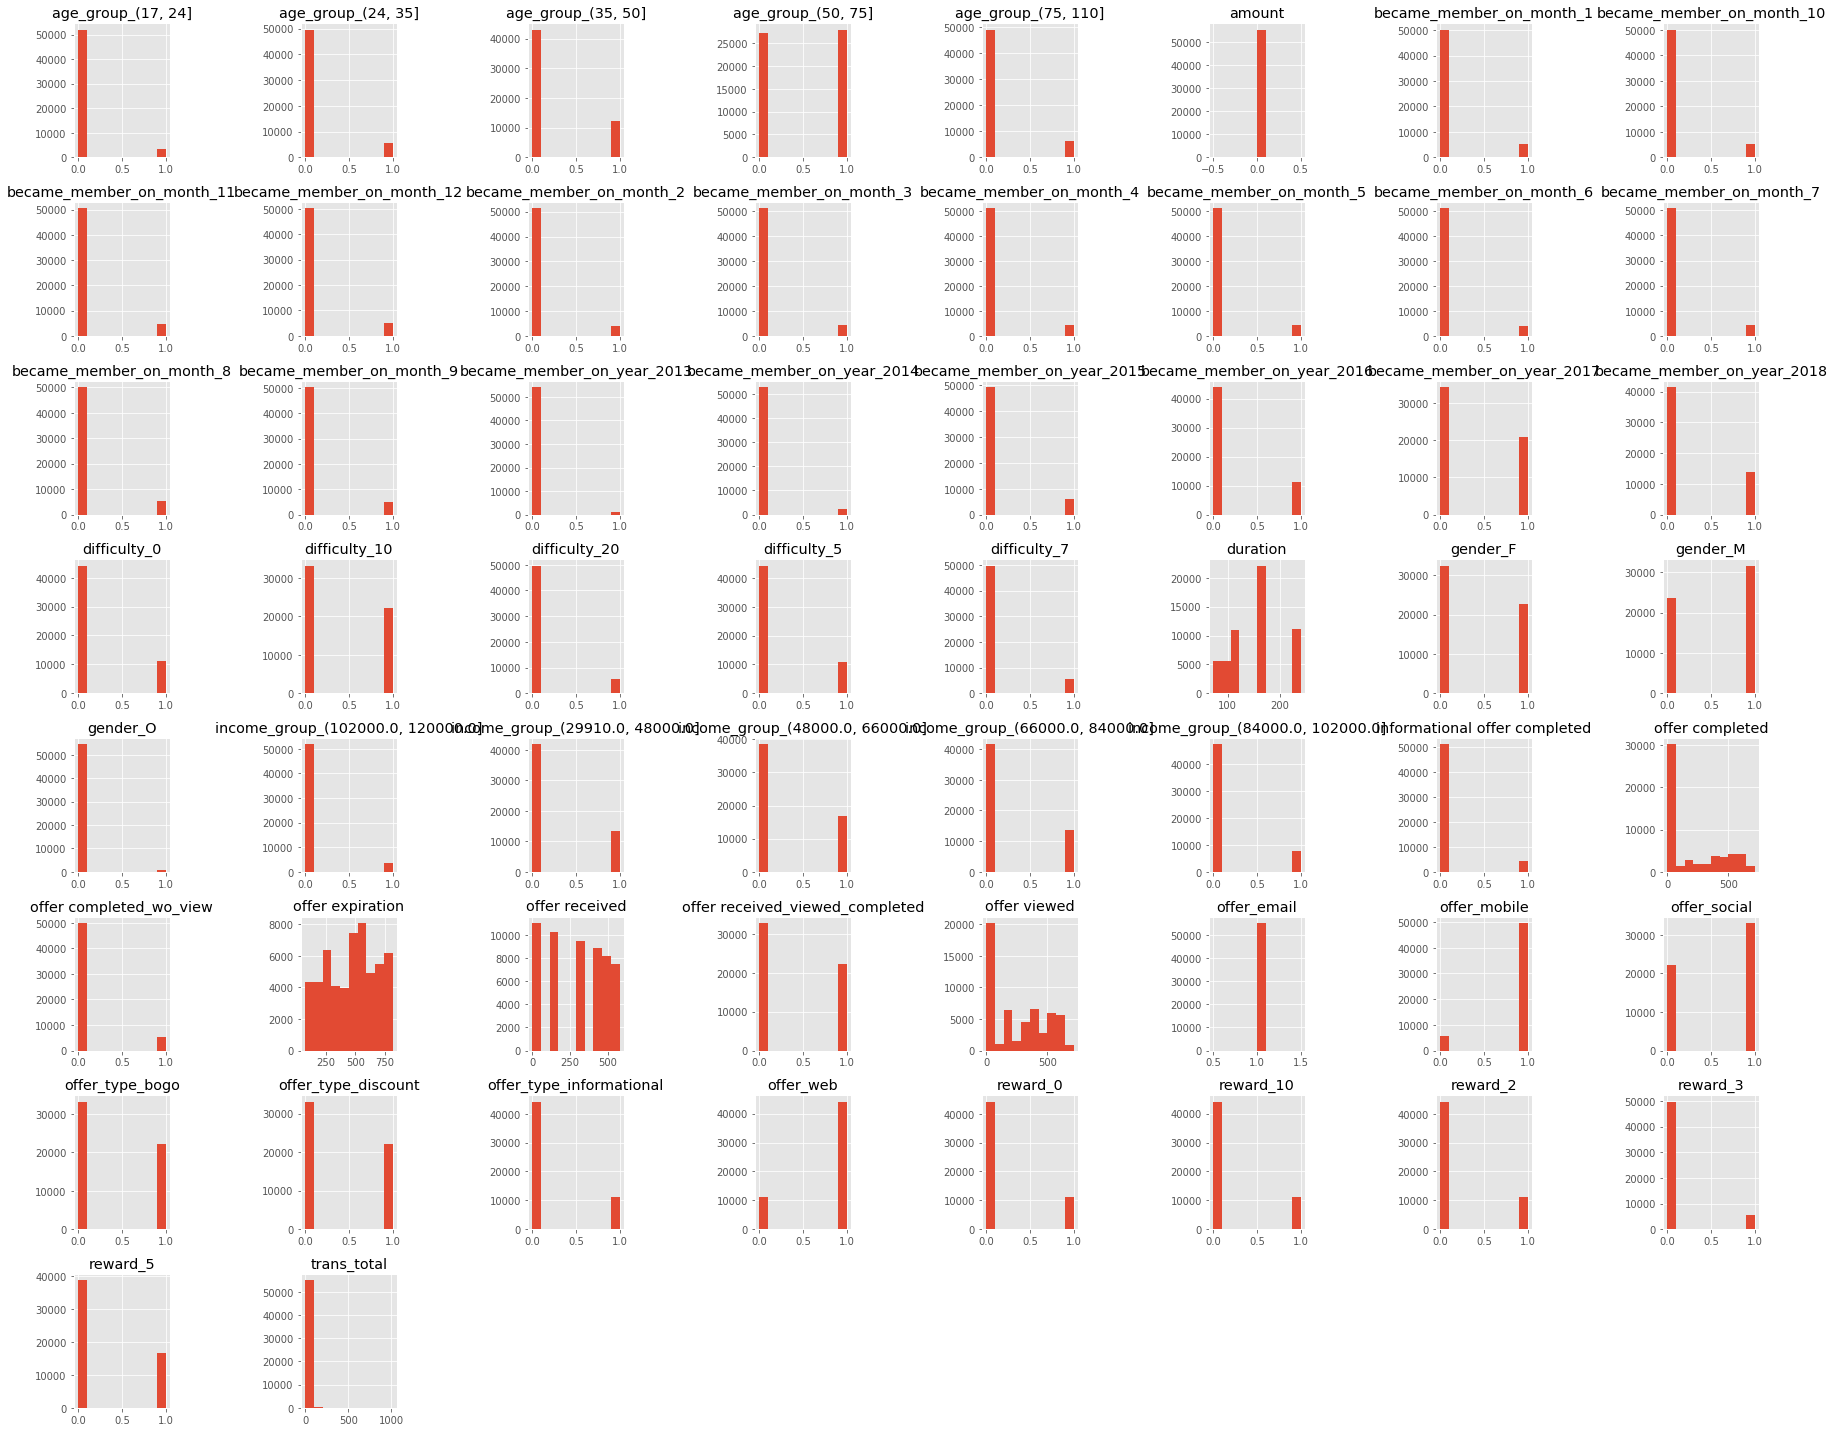

In [80]:
customer_offer_summary_flat.hist(figsize=(25,20))
plt.tight_layout();

plt.savefig('customer_offer_summary_hist.png')

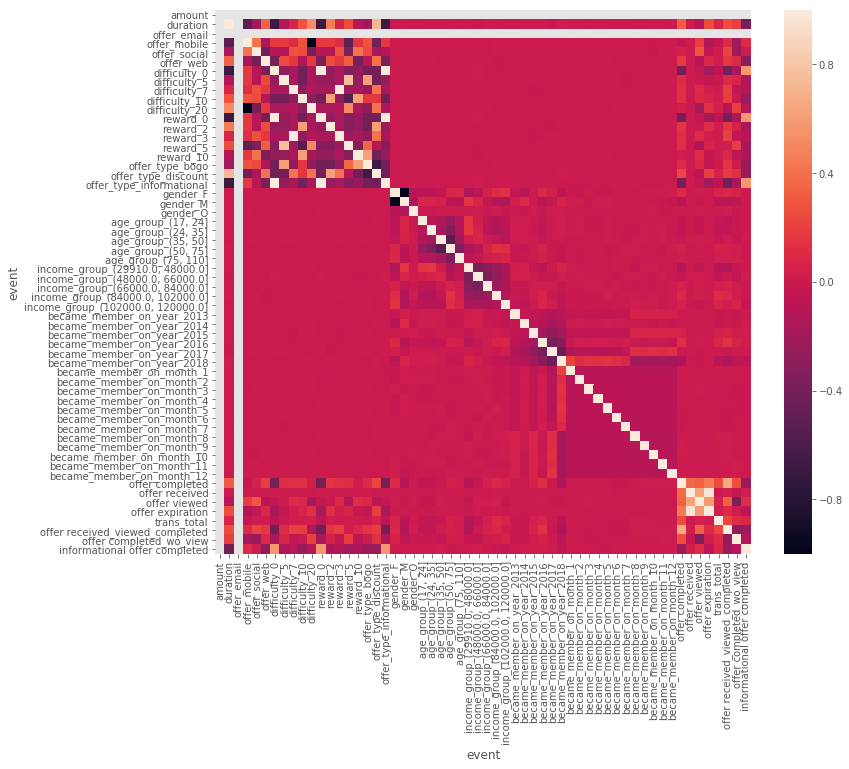

In [81]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(customer_offer_summary_flat.corr(),xticklabels=True, yticklabels=True, ax=ax);

plt.savefig('customer_offer_summary_heatmap.png')

In [82]:
# Drop fields that will not be used in model

drop_fields = ['customer_id', 'offer id', 'became_member_on', 'amount']
customer_offer_summary_flat = customer_offer_summary_flat.drop(drop_fields, axis=1)

In [83]:
customer_offer_summary_flat = pd.get_dummies(customer_offer_summary_flat, columns = ['duration'])
customer_offer_summary_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55222 entries, 0 to 55221
Data columns (total 61 columns):
offer_email                          55222 non-null float64
offer_mobile                         55222 non-null float64
offer_social                         55222 non-null float64
offer_web                            55222 non-null float64
difficulty_0                         55222 non-null float64
difficulty_5                         55222 non-null float64
difficulty_7                         55222 non-null float64
difficulty_10                        55222 non-null float64
difficulty_20                        55222 non-null float64
reward_0                             55222 non-null float64
reward_2                             55222 non-null float64
reward_3                             55222 non-null float64
reward_5                             55222 non-null float64
reward_10                            55222 non-null float64
offer_type_bogo                      55222 non-null

## 4. Evaluating Model Performance

In [84]:
customer_offer_summary_bogo = customer_offer_summary_flat[customer_offer_summary_flat['offer_type_bogo'] == 1]
customer_offer_summary_bogo = customer_offer_summary_bogo.drop(['offer_type_bogo', 'offer_type_discount', 'offer_type_informational'], axis=1)
customer_offer_summary_bogo.shape

(22062, 58)

In [85]:
customer_offer_summary_discount = customer_offer_summary_flat[customer_offer_summary_flat['offer_type_discount'] == 1]
customer_offer_summary_discount = customer_offer_summary_discount.drop(['offer_type_bogo', 'offer_type_discount', 'offer_type_informational'], axis=1)
customer_offer_summary_discount.shape

(22119, 58)

In [86]:
customer_offer_summary_info = customer_offer_summary_flat[customer_offer_summary_flat['offer_type_informational'] == 1]
customer_offer_summary_info = customer_offer_summary_info.drop(['offer_type_bogo', 'offer_type_discount', 'offer_type_informational'], axis=1)
customer_offer_summary_info.shape

(11041, 58)

In [87]:
def naive_predictor(output):
    TP = np.sum(output) # Counting the ones as this is the naive case
    FP = output.count() - TP # Specific to the naive case

    TN = 0 # No predicted negatives in the naive case
    FN = 0 # No predicted negatives in the naive case


    # TODO: Calculate accuracy, precision and recall
    accuracy = TP / output.count()
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)

    # TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
    fscore = (1 + 0.5**2) * (precision * recall) / ((0.5**2 * precision) + recall)

    # Print the results 
    print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))
    print('\n')

In [88]:
def rf_model_bogo_discount(df):
    drop_cols = ['offer received_viewed_completed', 'offer completed_wo_view', 'informational offer completed',
             'offer completed', 'offer received', 'offer viewed', 'offer expiration', 'trans_total']
    
    features = df.drop(drop_cols, axis=1)
    output = df['offer received_viewed_completed']
    
    naive_predictor(output)
    
    # Split the 'features' and 'output' data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        output, 
                                                        test_size = 0.2, 
                                                        random_state = 42)

    # Show the results of the split
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    print('\n')
    
    #Build Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)


    print('Training Accuracy: {}'.format(accuracy_score(y_train, predictions_train)))
    print('Training F-Score: {}'.format(fbeta_score(y_train, predictions_train, beta=0.5)))
    print('Test Accuracy: {}'.format(accuracy_score(y_test, predictions_test)))
    print('Test F-Score: {}'.format(fbeta_score(y_test, predictions_test, beta=0.5)))
    
    gridsearch(model, X_train, X_test, y_train, y_test)

In [89]:
def rf_model_informational(df):
    drop_cols = ['offer received_viewed_completed', 'offer completed_wo_view', 'informational offer completed',
             'offer completed', 'offer received', 'offer viewed', 'offer expiration', 'trans_total']
    
    features = df.drop(drop_cols, axis=1)
    output = df['informational offer completed']
    
    naive_predictor(output)
    
    # Split the 'features' and 'output' data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                        output, 
                                                        test_size = 0.2, 
                                                        random_state = 42)

    # Show the results of the split
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    print('\n')
    
    #Build Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)


    print('Training Accuracy: {}'.format(accuracy_score(y_train, predictions_train)))
    print('Training F-Score: {}'.format(fbeta_score(y_train, predictions_train, beta=0.5)))
    print('Test Accuracy: {}'.format(accuracy_score(y_test, predictions_test)))
    print('Test F-Score: {}'.format(fbeta_score(y_test, predictions_test, beta=0.5)))
    
    gridsearch(model, X_train, X_test, y_train, y_test)

In [90]:
def gridsearch(model, X_train, X_test, y_train, y_test):
    # TODO: Create the parameters list you wish to tune, using a dictionary if needed.
    parameters = {"max_depth": [15, 20, 30],
                  "n_estimators": [90, 100, 150],
                  "min_samples_split": [10, 20, 25],
                  "min_samples_leaf": [10, 12, 15],
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}

    # TODO: Make an fbeta_score scoring object using make_scorer()
    scorer = make_scorer(fbeta_score, beta=0.5)

    # TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
    grid_obj = GridSearchCV(model, param_grid=parameters, scoring=scorer, cv=5)

    # TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
    start = time() # Get start time
    grid_fit = grid_obj.fit(X_train, y_train)
    end = time() # Get end time

    print('grid_fit time to run: {:.4f}'.format(end - start))
    print('\n')

    # Get the estimator
    best_clf = grid_fit.best_estimator_
    importances = grid_fit.best_estimator_.feature_importances_

    # Make predictions using the unoptimized and model
    predictions = (model.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)

    # Report the before-and-afterscores
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}\n".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

    print(grid_fit.best_params_)
    print('\n')
    indices = np.argsort(importances)
    columns = X_train.columns.values[indices]
    values = importances[indices]
    print(indices)
    print(columns)
    print(values)
    
    feature_plot(importances, X_train, y_train)

In [91]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (12,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()

### 4.1 Bogo Model

Naive Predictor: [Accuracy score: 0.4960, F-score: 0.5516]


Training set has 17649 samples.
Testing set has 4413 samples.


Training Accuracy: 0.7719984135078475
Training F-Score: 0.7754986024918281
Test Accuracy: 0.6145479265805575
Test F-Score: 0.6106651376146789
grid_fit time to run: 2715.2132


Unoptimized model
------
Accuracy score on testing data: 0.6145
F-score on testing data: 0.6107

Optimized Model
------
Final accuracy score on the testing data: 0.6651
Final F-score on the testing data: 0.6621

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 90}


[ 0 46 45 11 10  9  8 49  6  1  4 16 27  3 39 41 21 34 37 42 28 43 35 44 38
 36 40 26 33 19 17 13  5 12 18  7 20 24 48 29 47 23  2 31 25 14 15 30 22 32]
['offer_email' 'duration_96.0' 'duration_72.0' 'reward_3' 'reward_2'
 'reward_0' 'difficulty_20' 'duration_240.0' 'difficulty_7' 'offer_mobile'
 'difficulty_0' 'gender_O' 'became_member_on_year_2013' 'o

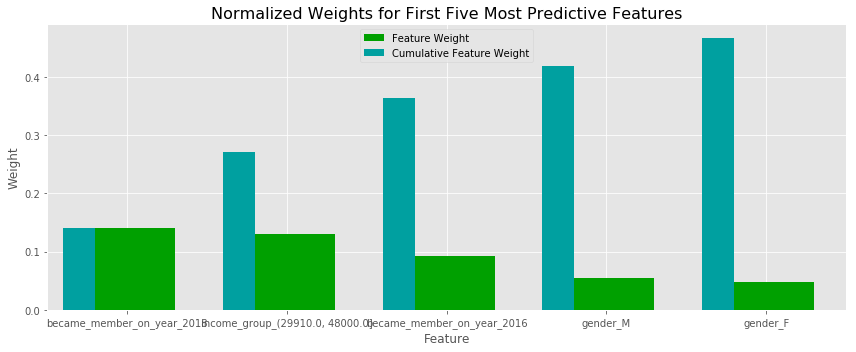

In [91]:
rf_model_bogo_discount(customer_offer_summary_bogo)

### 4.2 Discount Model

Naive Predictor: [Accuracy score: 0.5178, F-score: 0.5731]


Training set has 17695 samples.
Testing set has 4424 samples.


Training Accuracy: 0.7897711217858152
Training F-Score: 0.7994176354219921
Test Accuracy: 0.6824141048824593
Test F-Score: 0.6983215151243156
grid_fit time to run: 2642.2143


Unoptimized model
------
Accuracy score on testing data: 0.6824
F-score on testing data: 0.6983

Optimized Model
------
Final accuracy score on the testing data: 0.7231
Final F-score on the testing data: 0.7349

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 100}


[ 0 47 46  3  4  5 45  9 13 16 27 39 37 36 21 40 35 42 44 41 34 38 28 33 26
 43 17 19 20 23 24 18 15 14  7 29 25 11 31 10  6 48 49 22 30 12  8  1 32  2]
['offer_email' 'duration_120.0' 'duration_96.0' 'offer_web' 'difficulty_0'
 'difficulty_5' 'duration_72.0' 'reward_0' 'reward_10' 'gender_O'
 'became_member_on_year_2013' 'became_member_on_month_7'
 'beca

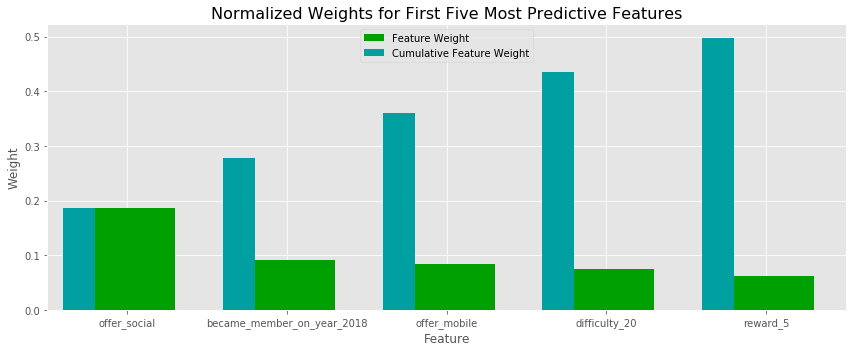

In [93]:
rf_model_bogo_discount(customer_offer_summary_discount)

### 4.3 Informational Model

Naive Predictor: [Accuracy score: 0.3763, F-score: 0.4300]


Training set has 8832 samples.
Testing set has 2209 samples.


Training Accuracy: 0.7703804347826086
Training F-Score: 0.7081948258418848
Test Accuracy: 0.6215482118605704
Test F-Score: 0.47119645494830137
grid_fit time to run: 1306.3569


Unoptimized model
------
Accuracy score on testing data: 0.6215
F-score on testing data: 0.4712

Optimized Model
------
Final accuracy score on the testing data: 0.6655
Final F-score on the testing data: 0.5258

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 100}


[ 0 47 48 13 12 11 10  9 49  7  1  4  8  6  5 16 27 39 37 38 34 41 44 28 21
 40 43 42 17 36 35 33 18 15 19 14 24 29 20 31 30 23 26 25 46  3 45 22  2 32]
['offer_email' 'duration_120.0' 'duration_168.0' 'reward_10' 'reward_5'
 'reward_3' 'reward_2' 'reward_0' 'duration_240.0' 'difficulty_10'
 'offer_mobile' 'difficulty_0' 'difficulty_20' 'difficulty_7'


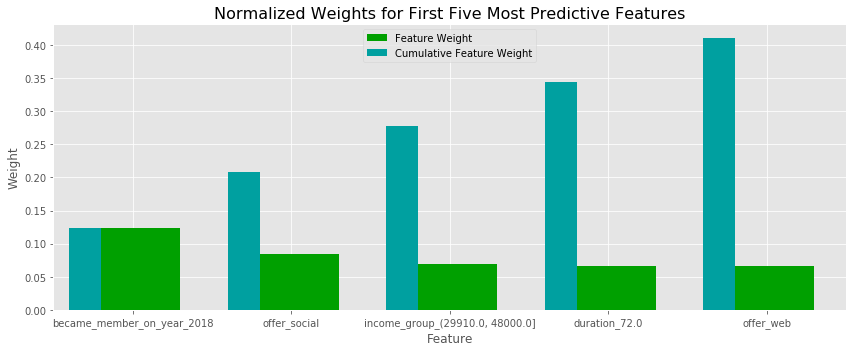

In [92]:
rf_model_informational(customer_offer_summary_info)